In [269]:
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

In [270]:
mode = 'multiroom'
minigrid_config = {'size': [200, 200], 'epsilon': 0.5, 'oracle': True}
env_id=None
set_seed(333)

# env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)
# obs = env.reset()
# plt.imshow(obs)

using seed 333


### Successor Features Heatmap

In [4]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


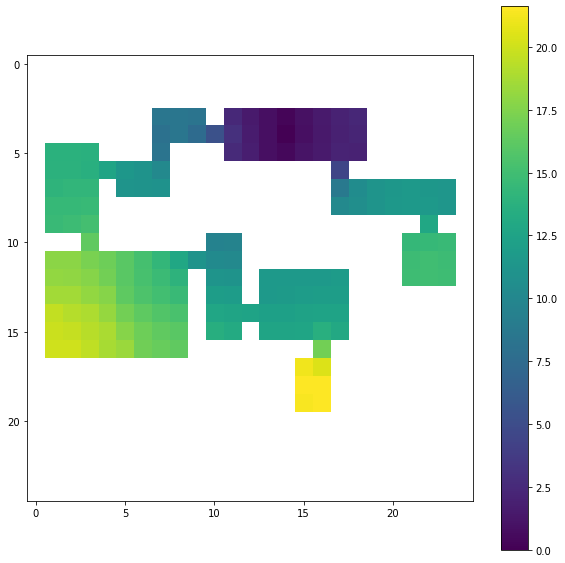

In [101]:
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', (14, 4), -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
plt.colorbar()

### Subgoal Q-Values

In [108]:
from sklearn_extra.cluster import KMedoids

In [7]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [8]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

using seed 333


In [9]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [10]:
params = torch.load(checkpoint, map_location=device)

In [271]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [12]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

IDFModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=1600, out_features=64, bias=True)
  )
  (inverse): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [113]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [188]:
state_dsr = action_dsr.mean(axis=2)

In [189]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [190]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [191]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [201]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

array([[ 9,  3],
       [ 1,  7],
       [10, 13],
       [21,  7],
       [15,  5],
       [ 4, 13],
       [15, 14],
       [15, 19]])

In [202]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

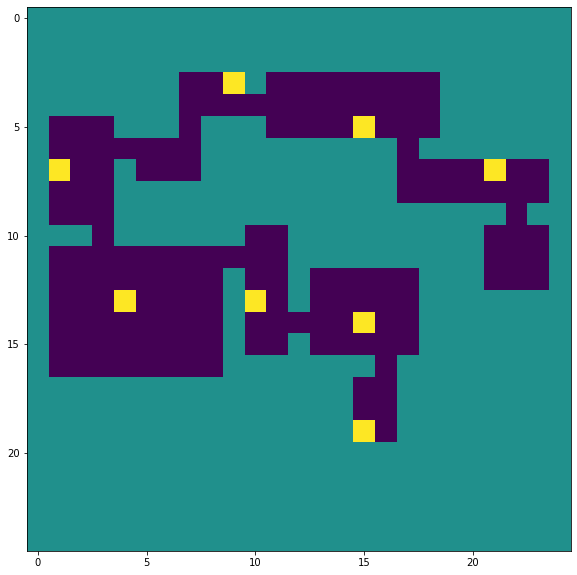

In [203]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [102]:
subgoal = (14, 4)

In [103]:
env.unwrapped.agent_pos = np.array(subgoal)

obs, _, _, _ = env.env.env.step(5)
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

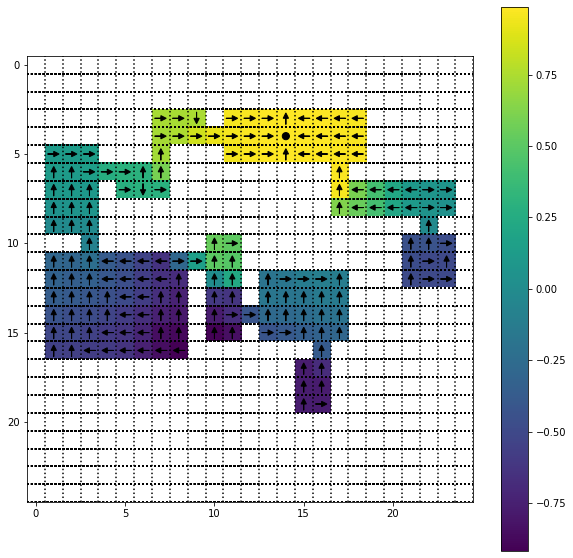

In [106]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='k')
            plt.gca().add_artist(circle)
        
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    
plt.colorbar()

### T-SNE Plots

In [56]:
import itertools
from sklearn.manifold import TSNE

In [60]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [65]:
raw_sf = dsr.mean(axis=(2, 3))

In [66]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [67]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [82]:
rooms = np.zeros((25, 25))

In [84]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [85]:
rooms = rooms.reshape(25 * 25)[~walls]

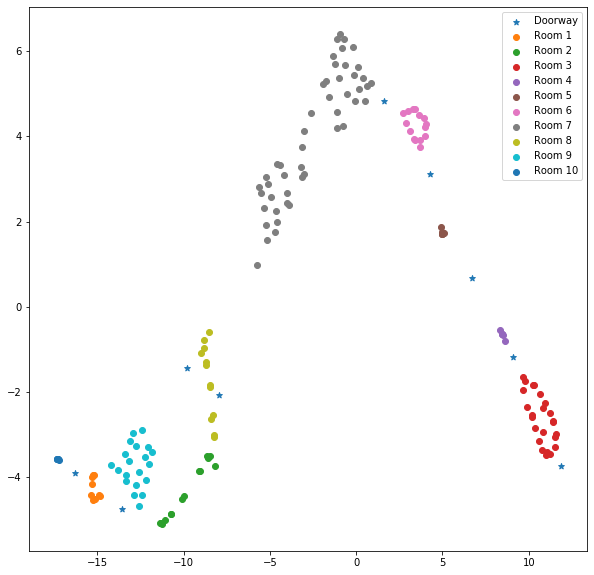

In [100]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()